In [2]:
import os
import sys
import datacube
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
from datacube.utils import geometry
from datacube.helpers import write_geotiff
from datacube.utils.geometry import CRS
from otps import TimePoint
from otps import predict_tide
from dateutil.relativedelta import relativedelta
from collections import Counter
import warnings

sys.path.append('../10_Scripts')
import SpatialTools, DEAPlotting

# Create datacube instance
dc = datacube.Datacube(app='Tidal geomedian filmstrips')
dc_upgrade = datacube.Datacube(config='/home/561/rt1527/.ard-interoperability_tmp.conf')


def date_range(start_date, end_date, freq = '1YS'):
    
    '''
    Generates a dictionary of from-to date ranges based on a start and end date, and
    a temporal frequency (e.g. annually or six-monthly etc).
    
    Frequencies are based on Panda's date offset objects - see the following list:
    https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects.
    Options include annual ('1YS'), every 6 months ('6MS') etc.
    
    Outputs a dictionary with each time range named by its starting date.
    '''    

    # Convert to list of from-to dates. 
    from_dates = pd.date_range(start_date, end_date, freq=freq)[:-1].astype(str).values
    to_dates = pd.date_range(start_date, end_date, freq=freq)[1:].astype(str).values
    
    # Combine into a dictionary. Starting dates for each range are used to name output files.
    date_ranges = {a: (a, b) for (a, b) in np.dstack([from_dates, to_dates])[0]}
    
    return date_ranges


def mostcommon_utm(dc, product, query):    
    
    '''
    Takes a given query and returns the most common UTM zone for 
    observations returned for that spatial extent.
    
    '''
    
    # List of matching products
    matching_datasets = dc.find_datasets(product=product, **query)
    
    # Extract all CRSs
    crs_list = [str(i.crs) for i in matching_datasets]    
   
    # Identify most common CRS
    crs_counts = Counter(crs_list)    
    crs_mostcommon = crs_counts.most_common(1)[0][0]

    # Warn user if multiple CRSs are encountered
    if len(crs_counts.keys()) > 1:

        warnings.warn(f'Multiple UTM zones {list(crs_counts.keys())} were returned for this query.' 
                      f'Defaulting to the most common zone: {crs_mostcommon}', UserWarning)
    
    return crs_mostcommon


def tidal_tag(ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False):
    
    if not tidepost_lat or not tidepost_lon:

        tidepost_lon, tidepost_lat = ds.extent.centroid.to_crs(crs=CRS('EPSG:4326')).coords[0]
        print(f'Setting tide post from dataset centroid: {tidepost_lon}, {tidepost_lat}')

    else:
        print(f'Using user-supplied tide post: {tidepost_lon}, {tidepost_lat}')

    # Use the tidal mode to compute tide heights for each observation:
    obs_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()
    obs_timepoints = [TimePoint(tidepost_lon, tidepost_lat, dt) for dt in obs_datetimes]
    obs_predictedtides = predict_tide(obs_timepoints)

    # If tides cannot be successfully modeled (e.g. if the centre of the xarray dataset 
    # is located is over land), raise an exception 
    if len(obs_predictedtides) == 0:

        raise ValueError(f'Tides could not be modelled for dataset centroid located at '
                         f'{tidepost_lon}, {tidepost_lat}. This can happen if this coordinate '
                         f'occurs over land. Please manually specify a tide modelling post '
                         f'located over water using the `tidepost_lat` and `tidepost_lon` parameters.')

    else:

        # Extract tide heights
        obs_tideheights = [predictedtide.tide_m for predictedtide in obs_predictedtides]

        # Assign tide heights to the dataset as a new variable
        ds['tide_heights'] = xr.DataArray(obs_tideheights, [('time', ds.time)])

        # If swap_dims = True, make tide height the primary dimension instead of time
        if swap_dims:

            # Swap dimensions and sort by tide height
            ds = ds.swap_dims({'time': 'tide_heights'})
            ds = ds.sortby('tide_heights')     

        return ds

from scipy import stats
import pandas as pd

def change_regress(row, x_vals, x_labels, std_dev=3):
    
    # Extract x (time) and y (distance) values
    x = x_vals
    y = row.values[1:].astype(np.float)
    
    # Drop NAN rows
    xy_df = np.vstack([x, y]).T
    is_valid = ~np.isnan(xy_df).any(axis=1)
    xy_df = xy_df[is_valid]
    valid_labels = x_labels[is_valid]
    
    # Remove outliers
    outlier_bool = (np.abs(stats.zscore(xy_df)) < float(std_dev)).all(axis=1)
    xy_df = xy_df[outlier_bool]
        
    # Compute linear regression
    lin_reg = stats.linregress(x=xy_df[:,0], 
                               y=xy_df[:,1])
    
    # Return slope, p-values and list of outlier years excluded from regression   
    return pd.Series({'slope': np.round(lin_reg.slope, 2), 
                      'pvalue': np.round(lin_reg.pvalue, 3),
                      'outliers': str(valid_labels[~outlier_bool]).replace('[', '').replace(']', '')})


import warnings
warnings.simplefilter('ignore', FutureWarning)


In [3]:
# # todo
# 1) Add SOI stats to contour file
# 2) Fix outlier data for SOI/el nino years
# 3) Add pos/neg SOI as well as La Nina/El Nino SOI
# 4) Clip by smartline? Excluding estauries?

## Set spatial query

In [4]:
# # Option 1: For a set of discontinuous or unevenly sized time steps (e.g. climatic periods, before-after development).
# # Each set of dates will be exported as an individual shoreline
# study_area = 'tweed_custom'  # Name used as prefix for output files
# lat_extents = (-28.15, -28.19)   
# lon_extents = (153.51, 153.56)
# time_periods = {'elnino_1': ('1991-01-01', '1995-01-01'),
#                 'lanina_1': ('1998-02-01', '2001-01-01')}

# # Option 1: For a set of discontinuous or unevenly sized time steps (e.g. climatic periods, before-after development).
# study_area = 'adelaide_custom'  # Name used as prefix for output files
# lat_extents = (-34.88, -34.96)   
# lon_extents = (138.48, 138.52)
# time_periods = {'elnino_1': ('1990-01-01', '1991-06-01'),
#                 'lanina_1': ('1993-01-01', '1994-01-01'),
#                 'elnino_2': ('1994-01-01', '1995-01-01')}

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'adelaide'  # Name used as prefix for output files
# lat_extents = (-34.755, -35.3391)   
# lon_extents = (138.4194, 138.5249)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
study_area = 'cabarita'  # Name used as prefix for output files
lat_extents = (-27.65, -29.43)   
lon_extents = (153.3197, 153.65)
time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'avoca'  # Name used as prefix for output files
# lat_extents = (-32.8168, -34.0528)   
# lon_extents = (151.0785, 151.9347)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'pilbara'  # Name used as prefix for output files
# lat_extents = ( -21.2890, -22.100)   
# lon_extents = (114.4546, 115.5185)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'pointstuart'  # Name used as prefix for output files
# lat_extents = (-12.00, -12.60)   
# lon_extents = (130.8, 132.59)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'cabarita'  # Name used as prefix for output files
# lat_extents = (-28.1387, -29.43)   
# lon_extents = (153.3197, 153.65)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')

# # Option 2: For a set of evenly spaced time steps (e.g. annually or monthly):
# study_area = 'cabarita_small'  # Name used as prefix for output files
# lat_extents = (-28.0530, -28.4530)      
# lon_extents = (153.4063, 153.6063)
# time_periods = date_range('1987-01-01', '2019-01-01', freq = '1YS')


# Optional parameters
min_tide_perc = 0.5  # Minumum percentile of the observed tidal range to include (e.g. 0.5 = median tide height)
max_tide_perc = 1.0  # Maximum percentile of the observed tidal range to include (e.g. 1.0 = maximum tide height)
water_index = 'mndwi'  # Water index used to extract waterlines. Options are 'mndwi', 'ndwi', 'awei_s', 'awei_ns'
index_threshold = 0.1  # Threshold used to extract waterlines. Generally, this will be near to 0
min_vertices = 30  # Minimum size of waterlines in vertexes to extract. Larger values remove small, isolated waterlines
sensors = ['ls5', 'ls7', 'ls8']  # Landsat satellites to load (e.g. Landsat 5, 7, 8)

# Preview area
DEAPlotting.display_map(x=lon_extents, y=lat_extents, crs='EPSG:4326')

## Load satellite data

This will first attempt to extract data from the collection upgrade DEA Landsat Collection 3 data to avoid jagged resampling artefacts in the output contours. If this is not possible, it will revert to importing DEA Landsat Collection 2 data which will produce jagged contours due to nearest neighbour resampling that was originally used when the data was ingested into the datacube.

In [5]:
# If output data and figure directories doesn't exist, create them
if not os.path.isdir('output_data/{}/'.format(study_area)):
    os.makedirs('output_data/{}/'.format(study_area))

# Create a query based on lat and lon extents and all of time. This is filtered by tide
# and time periods (using `dask`) before any data is actually loaded
query = {'y': lat_extents,
         'x': lon_extents,
         'crs': 'EPSG:4326',
         'time': ('1986-01-01', '2020-01-01')}

# Output dicts to hold entire time-series for each sensor
sensor_dict = {}

# First try using collection upgrade DEA Landsat Collection 3 data to avoid jagged resampling artefacts
try:

    # Obtain output CRS by taking the most common value of matching Landsat 5 observations
    output_crs = mostcommon_utm(dc=dc_upgrade, product='ls5_ard', query=query)

    # For each sensor, dask load data and compute tide heights for each sensor
    for sensor in sensors:    

        # Return observations matching query without actually loading them using dask
        sensor_ds = dc_upgrade.load(product='{}_ard'.format(sensor), 
                                    measurements=['nbart_red', 'nbart_green', 'nbart_blue', 
                                                  'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'fmask'],
                                    group_by='solar_day', 
                                    output_crs=output_crs,
                                    resolution=(-30, 30),
                                    gqa_iterative_mean_xy=(0, 1),  # Tolerate no more than a one pixel shift
                                    align=(15, 15),  # Fix for 15m NW offset in collection upgrade
                                    dask_chunks={'time': 1},  # Lazily load data
                                    **query)  

        # Mask data by pixel quality/fmask to remove cloud, shadow, nodata etc
        bad_quality = (sensor_ds.fmask == 0) | (sensor_ds.fmask == 2) | (sensor_ds.fmask == 3)
        sensor_ds = sensor_ds.where(~bad_quality)    

        # Append results for each sensor to a dictionary with sensor name as the key
        sensor_ds = sensor_ds.rename({'nbart_red': 'red', 'nbart_blue': 'blue', 'nbart_green': 'green', 
                                      'nbart_nir': 'nir', 'nbart_swir_1': 'swir1', 'nbart_swir_2': 'swir2'})
        
        # Append cloud filtered sensor data to dictionary
        sensor_dict[sensor] = sensor_ds
        
# If DEA Collection 3 data is not available, revert to using DEA Landsat Collection 2
except IndexError:
    
    print('Collection upgrade data (DEA Landsat Collection 3) is unavailable for this location. '
          'Reverting to DEA Landsat Collection 2 (contours will be affected by resampling artefacts)')    
  
    # For each sensor, dask load data and compute tide heights for each sensor
    for sensor in sensors:            
    
        # Return observations matching query without actually loading them using dask
        sensor_ds = dc.load(product = '{}_nbart_albers'.format(sensor), 
                         group_by = 'solar_day', 
                         measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2'],
                         dask_chunks={'time': 1},
                         **query)

        # Load PQ data matching query without actually loading them using dask
        pq_ds = dc.load(product = '{}_pq_albers'.format(sensor),
                        group_by = 'solar_day',
                        fuse_func=ga_pq_fuser, 
                        dask_chunks={'time': 1},
                        **query)
        
        # Filter to keep only observations that have matching PQ data 
        time = (sensor_ds.time - pq_ds.time).time
        sensor_ds = sensor_ds.sel(time=time)
        pq_ds = pq_ds.sel(time=time)               

        # Identify pixels with no clouds/shadows in either ACCA for Fmask
        good_quality = masking.make_mask(pq_ds.pixelquality,
                                         cloud_acca='no_cloud',
                                         cloud_shadow_acca='no_cloud_shadow',
                                         cloud_shadow_fmask='no_cloud_shadow',
                                         cloud_fmask='no_cloud',
                                         blue_saturated=False,
                                         green_saturated=False,
                                         red_saturated=False,
                                         nir_saturated=False,
                                         swir1_saturated=False,
                                         swir2_saturated=False,
                                         contiguous=True)

        # Apply mask to set all PQ-affected pixels to NaN and set nodata to NaN
        sensor_ds = sensor_ds.where(good_quality)
        sensor_ds = masking.mask_invalid_data(sensor_ds)   
        
        # Append cloud filtered sensor data to dictionary
        sensor_dict[sensor] = sensor_ds

# Combine into a single xarray dataset
all_ds = xr.concat(sensor_dict.values(), dim='time')
all_ds = all_ds.sortby('time')

# Tag with tide heights and compute percentile tide heights
# all_ds = tidal_tag(all_ds, tidepost_lat=None, tidepost_lon=None, swap_dims=False)
all_ds = tidal_tag(all_ds, tidepost_lat=-28.4939, tidepost_lon=153.6109, swap_dims=False)  
min_tide_thresh = all_ds.tide_heights.quantile(min_tide_perc).item()
max_tide_thresh = all_ds.tide_heights.quantile(max_tide_perc).item()

# Clip to tide range between min and max percentiles
all_ds = all_ds.sel(time=(all_ds.tide_heights > min_tide_thresh) & (all_ds.tide_heights <= max_tide_thresh))

Using user-supplied tide post: 153.6109, -28.4939


## Generate median water index composites for each time period in `time_periods`

In [6]:
# Compute water indices
all_ds["ndwi"] = (all_ds.green - all_ds.nir) / (all_ds.green + all_ds.nir)
all_ds["mndwi"] = (all_ds.green - all_ds.swir1) / (all_ds.green + all_ds.swir1)
all_ds["awei_ns"] = (4 * (all_ds.green * 0.0001 - all_ds.swir1 * 0.0001) -
                    (0.25 * all_ds.nir * 0.0001 + 2.75 * all_ds.swir2 * 0.0001))
all_ds["awei_s"] = (all_ds.blue * 0.0001 + 2.5 * all_ds.green * 0.0001 - 
                    1.5 * (all_ds.nir * 0.0001 + all_ds.swir1 * 0.0001) - 0.25 * all_ds.swir2 * 0.0001)

# Create median composites for each timestep
composite_list = []

# Actually load data for the first time for each time period, and generate median water index composite
for name, time_period in time_periods.items():
    
    print(f'Generating median composites for timestep {name} (from {time_period[0]} to {time_period[1]})')
    
    # Load time period subset
    subset_ds = all_ds.sel(time=slice(time_period[0], time_period[1]))   
    
    # Compute median of water index and tide heights
    median_comp = subset_ds[['tide_heights', water_index]].compute().median(dim='time', keep_attrs=True)
    
    # Compute number of observations and min//max/standard deviation of tide heights
    median_comp['tide_m_min'] = subset_ds.tide_heights.min(dim='time', keep_attrs=True)
    median_comp['tide_m_max'] = subset_ds.tide_heights.max(dim='time', keep_attrs=True)
    median_comp['tide_m_std'] = subset_ds.tide_heights.std(dim='time', keep_attrs=True)
    median_comp['obs_n'] = len(subset_ds.time)
    
    # Export to file
    filename = f'output_data/{study_area}/{study_area}_{name}_{water_index}.tif'
    write_geotiff(filename=filename, dataset=median_comp[[water_index]])    
    
    composite_list.append(median_comp)
    
# Combine into one dataset with dimension names
composite_ds = xr.concat(composite_list, dim='timeperiod')
composite_ds = composite_ds.assign_coords(timeperiod = list(time_periods.keys()))
print(composite_ds)


Generating median composites for timestep 1987-01-01 (from 1987-01-01 to 1988-01-01)
Generating median composites for timestep 1988-01-01 (from 1988-01-01 to 1989-01-01)
Generating median composites for timestep 1989-01-01 (from 1989-01-01 to 1990-01-01)
Generating median composites for timestep 1990-01-01 (from 1990-01-01 to 1991-01-01)
Generating median composites for timestep 1991-01-01 (from 1991-01-01 to 1992-01-01)
Generating median composites for timestep 1992-01-01 (from 1992-01-01 to 1993-01-01)
Generating median composites for timestep 1993-01-01 (from 1993-01-01 to 1994-01-01)
Generating median composites for timestep 1994-01-01 (from 1994-01-01 to 1995-01-01)
Generating median composites for timestep 1995-01-01 (from 1995-01-01 to 1996-01-01)
Generating median composites for timestep 1996-01-01 (from 1996-01-01 to 1997-01-01)
Generating median composites for timestep 1997-01-01 (from 1997-01-01 to 1998-01-01)
Generating median composites for timestep 1998-01-01 (from 1998-0

## Extract waterline contours

Operating in single z-value, multiple arrays mode
Exporting contour shapefile to output_data/cabarita/cabarita_mndwi_0.1.shp


,obs_n,tide_m_ave,tide_m_std,tide_m_min,tide_m_max,geometry
timeperiod,,,,,,
1987-01-01,3,0.43,0.02,0.42,0.48,"(LINESTRING (531892.7321528724 -3058470, 53187..."
1988-01-01,9,0.54,0.25,0.22,1.12,"(LINESTRING (531905.9351452476 -3058470, 53190..."
1989-01-01,9,0.67,0.17,0.41,0.96,"(LINESTRING (531896.2219679613 -3058470, 53188..."
1990-01-01,8,0.62,0.23,0.21,0.91,"(LINESTRING (531905.1434569629 -3058470, 53190..."
1991-01-01,8,0.57,0.18,0.23,0.81,"(LINESTRING (531915.6916682705 -3058470, 53190..."
1992-01-01,10,0.43,0.24,0.17,0.96,"(LINESTRING (531916.337539803 -3058470, 531900..."
1993-01-01,10,0.30,0.31,0.12,1.08,"(LINESTRING (531909.4263047101 -3058470, 53190..."
1994-01-01,12,0.27,0.33,0.12,1.16,"(LINESTRING (531895.5187375291 -3058470, 53189..."
1995-01-01,11,0.29,0.23,0.11,0.82,"(LINESTRING (531881.6677141702 -3058470, 53187..."


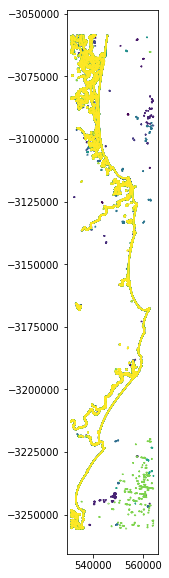

In [7]:
# Prepare attributes as input to contour extract
attribute_data = {'timeperiod': composite_ds.timeperiod.values.tolist(),
                  'obs_n': composite_ds.obs_n.values.tolist(),                  
                  'tide_m_ave': composite_ds.tide_heights.values.tolist(),
                  'tide_m_std': composite_ds.tide_m_std.values.tolist(),
                  'tide_m_min': composite_ds.tide_m_min.values.tolist(),
                  'tide_m_max': composite_ds.tide_m_max.values.tolist()}  
attribute_dtypes = {'timeperiod': 'str', 'obs_n': 'int', 'tide_m_ave': 'float:15.2', 
                    'tide_m_std': 'float:15.2', 'tide_m_min': 'float:15.2', 'tide_m_max': 'float:15.2'}

# Extract contours with custom attribute fields:
contours_gdf = SpatialTools.contour_extract(z_values=[index_threshold],
                                   ds_array=composite_ds[water_index],
                                   ds_crs=composite_ds.crs,
                                   ds_affine=composite_ds.geobox.transform,
                                   output_shp=f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}.shp',
                                   min_vertices=min_vertices,  
                                   attribute_data=attribute_data,
                                   attribute_dtypes=attribute_dtypes,
                                   verbose=False,                                   
                                   dim='timeperiod')

# Plot contours
import matplotlib.pyplot as plt
contours_gdf = contours_gdf.set_index('timeperiod')
fig, ax = plt.subplots(figsize=(10, 10))
contours_gdf.plot(ax=ax, cmap='viridis')
contours_gdf

## Compute change statistics

In [8]:
import fiona
from shapely.geometry import mapping
from shapely.ops import nearest_points
from shapely.geometry import Point, LineString, MultiPoint
import geopandas as gpd

# Read in contours
# contours_gdf = gpd.read_file(f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}.shp')

# Set annual shoreline to use as a baseline
baseline_year = contours_gdf.index[0]
baseline_contour = contours_gdf.loc[baseline_year].geometry

# Set up output shapefile
schema = {'geometry': 'Point','properties': {'id': 'int'}}
baseline_points_shp = f'output_data/{study_area}/{study_area}_{water_index}_{index_threshold}_statistics.shp' 

with fiona.open(baseline_points_shp, 'w', 'ESRI Shapefile', schema, crs=contours_gdf.crs) as output:
    
    # create points every 30 meters along the line
    for i, distance in enumerate(range(0, int(baseline_contour.length), 30)):
         point = baseline_contour.interpolate(distance)   
         output.write({'geometry': mapping(point), 'properties': {'id': i}}) 


In [9]:
# Read points in as geopandas
points_gdf = gpd.read_file(baseline_points_shp)

# Copy geometry to baseline point
points_gdf['p_baseline'] = points_gdf.geometry
baseline_x_vals = points_gdf.geometry.x
baseline_y_vals = points_gdf.geometry.y

# Get array of water index values for baseline time period 
baseline_array = composite_ds.sel(timeperiod = baseline_year)[water_index]

# Iterate through all comparison years in contour gdf
for comp_year in contours_gdf.index.unique().values:

    print(comp_year)

    # Set comparison contour
    comp_contour = contours_gdf.loc[comp_year].geometry

    # Find nearest point on comparison contour
    points_gdf[f'p_{comp_year}'] = points_gdf.apply(lambda x: 
                                                    nearest_points(x.p_baseline, comp_contour)[1], axis=1)

    # Compute distance between baseline and comparison year points
    points_gdf[f'{comp_year}'] = points_gdf.apply(lambda x: 
                                                  x.geometry.distance(x[f'p_{comp_year}']), axis=1)

    # Extract comparison array
    comp_array = composite_ds.sel(timeperiod = comp_year)[water_index]

    # Convert baseline and comparison year points to geoseries to allow easy access to x and y coords
    comp_x_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).x
    comp_y_vals = gpd.GeoSeries(points_gdf[f'p_{comp_year}']).y

    # Sample NDWI values from arrays based on baseline and comparison points
    baseline_x_vals = xr.DataArray(baseline_x_vals, dims='z')
    baseline_y_vals = xr.DataArray(baseline_y_vals, dims='z')
    comp_x_vals = xr.DataArray(comp_x_vals, dims='z')
    comp_y_vals = xr.DataArray(comp_y_vals, dims='z')   
    points_gdf['index_comp_p1'] = comp_array.interp(x=baseline_x_vals, y=baseline_y_vals)
    points_gdf['index_baseline_p2'] = baseline_array.interp(x=comp_x_vals, y=comp_y_vals)

    # Compute directionality of change (negative = erosion, positive = accretion)    
    points_gdf['loss_gain'] = (points_gdf.index_baseline_p2 > points_gdf.index_comp_p1).astype(int).replace(to_replace=0, value=-1)
    points_gdf[f'{comp_year}'] = points_gdf[f'{comp_year}'] * points_gdf.loss_gain

# Keep required columns
points_gdf = points_gdf[['geometry'] + contours_gdf.index.unique().values.tolist()]
points_gdf = points_gdf.round(2)

# Identify dates for regression
x_years = np.array([int(i[:4]) for i in points_gdf.columns[1:]])

# Identify SOI values for regression
soi_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/raw_data/SOI_EastAnglia.txt', 
                     sep='\t', skiprows=1, usecols=['year', 'annual average'], index_col='year')
soi_df = soi_df.rename({'annual average': 'annual_SOI'}, axis=1)
x_soi = soi_df.loc[x_years].annual_SOI.values

# Identify La Nina / El Nino years
lan_eln = np.array(['ElN', 'LaN', 'LaN', 'na', 'ElN', 'ElN', 'ElN', 'ElN', 'na', 'na', 'ElN', 
                    'LaN', 'LaN', 'LaN', 'na', 'ElN', 'na', 'na', 'na', 'ElN', 'LaN', 'LaN', 
                    'ElN', 'LaN', 'LaN', 'na', 'na', 'na', 'ElN', 'na', 'na', 'na'])
lan_eln_df = pd.DataFrame({'year': range(1987, 2019), 'lan_eln': lan_eln}).set_index('year')
x_lan_eln = lan_eln_df.loc[x_years].lan_eln.values

# Get custom x values
x_neg = np.where(x_soi >= 0, x_soi, np.nan)
x_pos = np.where(x_soi <= 0, x_soi, np.nan)
x_lan = np.where(x_lan_eln == 'LaN', x_soi, np.nan)
x_eln = np.where(x_lan_eln == 'ElN', x_soi, np.nan)

# Compute change rates
rate_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_years, x_labels = x_years, std_dev=3), axis=1)
soi_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_soi, x_labels = x_years, std_dev=3), axis=1)
neg_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_neg, x_labels = x_years, std_dev=3), axis=1)
pos_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_pos, x_labels = x_years, std_dev=3), axis=1)
eln_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_eln, x_labels = x_years, std_dev=3), axis=1)
lan_out = points_gdf.apply(lambda x: change_regress(x, x_vals = x_lan, x_labels = x_years, std_dev=3), axis=1)
points_gdf[['mov_rate', 'mov_sig', 'mov_outl']] = rate_out
points_gdf[['soi_rate', 'soi_sig', 'soi_outl']] = soi_out
points_gdf[['neg_rate', 'neg_sig', 'neg_outl']] = neg_out
points_gdf[['pos_rate', 'pos_sig', 'pos_outl']] = pos_out
points_gdf[['eln_rate', 'eln_sig', 'eln_outl']] = eln_out
points_gdf[['lan_rate', 'lan_sig', 'lan_outl']] = lan_out

# Set insignificant rates to nan
points_gdf.loc[points_gdf.mov_sig > 0.05, 'mov_rate'] = np.nan
points_gdf.loc[points_gdf.soi_sig > 0.05, 'soi_rate'] = np.nan
points_gdf.loc[points_gdf.neg_sig > 0.05, 'neg_rate'] = np.nan
points_gdf.loc[points_gdf.pos_sig > 0.05, 'pos_rate'] = np.nan
points_gdf.loc[points_gdf.eln_sig > 0.05, 'eln_rate'] = np.nan
points_gdf.loc[points_gdf.lan_sig > 0.05, 'lan_rate'] = np.nan

# Export to file
points_gdf.crs = str(composite_ds.crs)
points_gdf.to_file(baseline_points_shp)    


1987-01-01
1988-01-01
1989-01-01
1990-01-01
1991-01-01
1992-01-01
1993-01-01
1994-01-01
1995-01-01
1996-01-01
1997-01-01
1998-01-01
1999-01-01
2000-01-01
2001-01-01
2002-01-01
2003-01-01
2004-01-01
2005-01-01
2006-01-01
2007-01-01
2008-01-01
2009-01-01
2010-01-01
2011-01-01
2012-01-01
2013-01-01
2014-01-01
2015-01-01
2016-01-01
2017-01-01
2018-01-01


/g/data/v10/public/modules/dea-env/20190208/lib/python3.6/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


In [10]:
# # Read points in as geopandas
# points_gdf = gpd.read_file(output_file)

# # Copy geometry to baseline point
# points_gdf['p_baseline'] = points_gdf.geometry
# baseline_x_vals = points_gdf.geometry.x
# baseline_y_vals = points_gdf.geometry.y

# # Get array of water index values for baseline time period 
# baseline_array = composite_ds.sel(timeperiod = baseline_year)[water_index]
# baseline_array

# # Set comparison contour
# comp_year = '2014-01-01'
# comp_contour = contours_gdf.loc[comp_year].geometry

# # Add P2 point
# points_gdf[f'p_{comp_year}'] = points_gdf.apply(lambda x: 
#                                                 nearest_points(x.p_baseline, comp_contour)[1], axis=1)

# points_gdf.head()

In [11]:
# x_soi > 0

## Compute SOI stats file

In [12]:
# # Read points in as geopandas
# points_gdf = gpd.read_file('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/output_data/cabarita/cabarita_mndwi_0.1_statistics.shp')

# # Add point ID column
# points_gdf['point_id'] = [f'point_{i}' for i in range(points_gdf.shape[0])]

In [13]:
# # Read in SOI values
# soi_df = pd.read_csv('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/raw_data/SOI_EastAnglia.txt', sep='\t', skiprows=1)

# # Change format of dates
# soi_df['year'] = [f'{i}-01-01' for i in soi_df.year]

# # # Rename SOI field
# # soi_df = soi_df.rename({'annual average': 'annual_SOI'}, axis=1)
# # soi_df['annual_SOI'] = soi_df.iloc[:, 2:-1].apply(lambda x: max(x.min(), x.max(), key=abs), axis=1)  
# soi_df['annual_SOI'] = soi_df.iloc[:, 2:-1].apply(np.nanmedian, axis=1)  
# soi_df = soi_df.loc[:, ['year', 'annual_SOI']]
# soi_df.head()

In [14]:
# points_melt_df = points_gdf.melt(id_vars=['point_id', 'rate_chang', 'rate_sig'], 
#                                  value_vars=points_gdf.columns[0:-5], var_name='year', value_name='annual_move')

In [15]:
# points_melt_df = points_melt_df.merge(soi_df, on='year')
# points_melt_df.head()


In [16]:
# points_melt_df.crs = 'EPSG:32656'
# mostcommon_utm(dc=dc_upgrade, product='ls5_ard', query=query)

# points_melt_df.to_file('/g/data/r78/rt1527/dea-notebooks/Waterline_extraction/output_data/cabarita/cabarita_mndwi_0.1_soi.shp')

In [17]:
# # test = points_melt_df[(points_melt_df.year != '2012-01-01') & 
# #                (points_melt_df.rate_sig > 0.05) & 
# #                (points_melt_df.annual_move.abs() < 100)]

# test = points_melt_df

# test.plot.scatter(x='annual_SOI', y='annual_move', alpha=1.0)
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# model = sm.formula.ols(formula='annual_move ~ annual_SOI', data=test)
# res = model.fit()
# test.assign(fit=res.fittedvalues).plot(x='annual_SOI', y='fit', ax=plt.gca(), color='red')

In [18]:
# test = test[(points_melt_df.rate_sig > 0.05)].groupby('year').median()   #.plot.scatter(x='annual_SOI', y='annual_move', alpha=1.0)
# test.plot.scatter(x='annual_SOI', y='annual_move', alpha=1.0)
# import statsmodels.api as sm
# import matplotlib.pyplot as plt
# model = sm.formula.ols(formula='annual_move ~ annual_SOI', data=test)
# res = model.fit()
# test.assign(fit=res.fittedvalues).plot(x='annual_SOI', y='fit', ax=plt.gca(), color='red')

In [19]:
# test

In [20]:
# query = {'y': lat_extents,
#          'x': lon_extents,
#          'crs': 'EPSG:4326',
#          'time': ('1986-01-01', '2020-01-01')}